In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images, inverse_scale_image

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-05-19 11:45:31.401887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [102]:
tf.keras.backend.clear_session()

In [73]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## CESM Data

In [74]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images(dir_name)
data_socat, pco2_socat = preprocess_images(dir_name, socat = True)

val_data,val_pco2 = preprocess_images(val_dir_name,"035")
val_data_socat,val_pco2_socat = preprocess_images(val_dir_name,"035",socat=True)

INPUT_SHAPE=data_socat[0].shape
OUTPUT_SHAPE=pco2_socat[0].shape

In [81]:
base_model = tf.keras.models.load_model('../../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})

for layer in base_model.layers[:-4]:
    layer.trainable = False
    
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)


early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
callbacks=[early_stopings]

epochs = 20
batch_size = 16


history = base_model.fit(
    val_data,
    val_pco2,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(data, pco2),
    callbacks=callbacks,
)
    

pred = base_model.predict(val_data,verbose=True)

Epoch 1/20
27/27 [==============================] - 5s 157ms/step - loss: 7.0794 - val_loss: 6.6800
Epoch 2/20
27/27 [==============================] - 3s 129ms/step - loss: 4.0905 - val_loss: 6.0876
Epoch 3/20
27/27 [==============================] - 3s 129ms/step - loss: 3.9480 - val_loss: 5.9116
Epoch 4/20
27/27 [==============================] - 3s 129ms/step - loss: 3.9525 - val_loss: 6.8016
Epoch 5/20
27/27 [==============================] - 3s 129ms/step - loss: 3.9834 - val_loss: 6.1840
Epoch 6/20
27/27 [==============================] - 3s 129ms/step - loss: 3.9605 - val_loss: 6.3062
Epoch 7/20
27/27 [==============================] - 3s 130ms/step - loss: 3.9070 - val_loss: 5.6874
Epoch 8/20
27/27 [==============================] - 3s 129ms/step - loss: 3.9496 - val_loss: 5.4997
Epoch 9/20
27/27 [==============================] - 3s 129ms/step - loss: 3.9717 - val_loss: 6.4855
Epoch 10/20
27/27 [==============================] - 3s 129ms/step - loss: 3.9933 - val_loss: 6.2929

In [76]:
def inverse_scale_image(arr, df, socat=False):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    if socat:
        return inverse_scale_image_socat(arr, df)
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    y_true=np.nan_to_num(df)
    y_pred[y_true==0]=0
    #y_true = np.expand_dims(y_true, axis=3)

    return y_true,y_pred

In [82]:
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(val_dir_name,num="035")
y_true,y_pred = inverse_scale_image(pred,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat = np.nan_to_num(pco2t2.pCO2_socat.data)
y_pred_socat[y_true_socat==0]=0.0



In [83]:
print("Full RMSE score:")
a=custom_rmse(y_pred,y_true)
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat,y_true_socat)
print(b.numpy())



Full RMSE score:
11.114809982679573
SOCAT RMSE score:
11.12907233178544


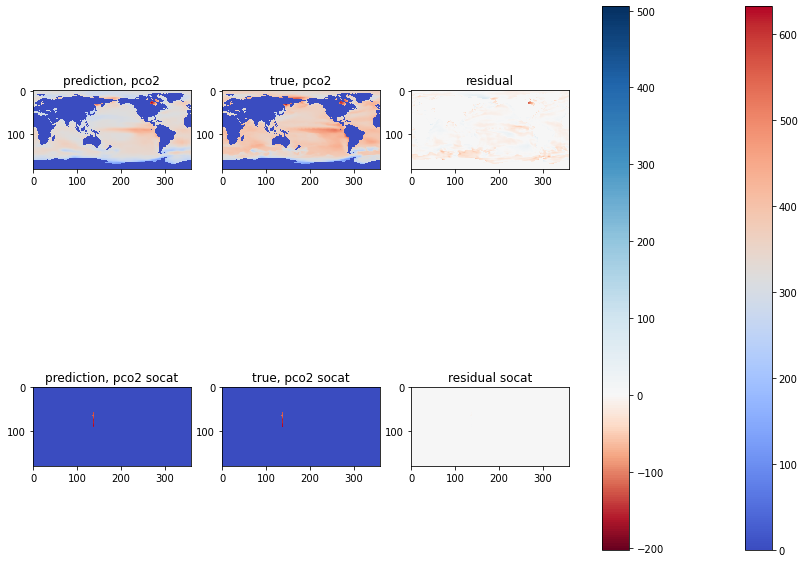

In [84]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 3,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, pco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, pco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[0][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[0][2].set_title("residual")
plt.colorbar(img2,ax=axis)


img3=axis[1][0].imshow(np.flipud(y_pred_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][0].set_title("prediction, pco2 socat")

img4=axis[1][1].imshow(np.flipud(y_true_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("true, pco2 socat")

diff=np.flipud(np.squeeze(y_true_socat[0]-y_pred_socat[0]))

img5=axis[1][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][2].set_title("residual socat")

plt.show()

In [86]:
rmses = []
rmses_socat = []

for i in range(421):    
    rmse =custom_rmse(y_pred[i],y_true[i]).numpy()
    rmses.append(rmse)
    rmse =custom_rmse(y_pred_socat[i],y_true_socat[i]).numpy()
    rmses_socat.append(rmse)
    

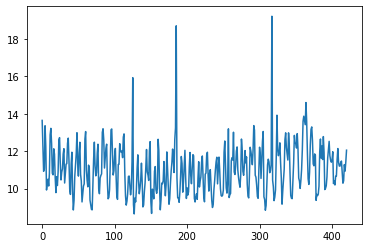

In [87]:
plt.plot(rmses)

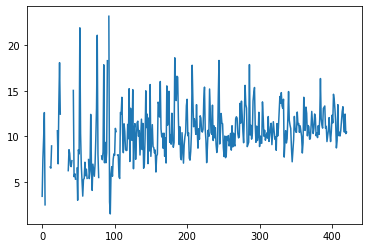

In [88]:
plt.plot(rmses_socat)

## MPI

In [95]:
def read_xarray(dir_name="",num="001",mpi=False,can=False):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature
    '''
    date="198201-201701"
    file_type = "CESM"
    if mpi:
        file_type ="MPI006"
        num=""
    elif can:
        file_type = "CanESM2r1r10"
        num=""
        date="198201-201712"
        
    
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}{num}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}{num}_1x1_{date}.nc')

    u10 = xr.open_dataset(f'{dir_name}/U10_2D_mon_{file_type}{num}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/data1/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    icefrac = xr.open_dataset(f'{dir_name}/iceFrac_2D_mon_{file_type}{num}_1x1_{date}.nc')

    patm = xr.open_dataset(f'{dir_name}/pATM_2D_mon_{file_type}{num}_1x1_{date}.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}{num}_1x1_{date}.nc')

    return chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2

def preprocess_images(dir_name, num="001",socat=False,mpi=False,can=False):
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num,mpi,can)
    
    if socat:

        chl_images = preprocess_image_reduced(chl.Chl_socat.data)
        mld_images = preprocess_image_reduced(mld.MLD_socat.data)
        sss_images = preprocess_image_reduced(sss.SSS_socat.data)
        sst_images = preprocess_image_reduced(sst.SST_socat.data)
        xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
        pco2_images = preprocess_image_reduced(pco2.pCO2_socat.data)
    
    else:
        chl_images = preprocess_image_reduced(chl.Chl.data)
        mld_images = preprocess_image_reduced(mld.MLD.data)
        sss_images = preprocess_image_reduced(sss.SSS.data)
        sst_images = preprocess_image_reduced(sst.SST.data)
        xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
        pco2_images = preprocess_image_reduced(pco2.pCO2.data)
    
    X = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images))
    X = X.reshape((421,180,360,5),order='F')

    return X, pco2_images

In [96]:
mpi_dir_name = "../../data/mpi_001"


data,pco2 = preprocess_images(mpi_dir_name,mpi=True)
data_socat, pco2_socat = preprocess_images(mpi_dir_name, socat = True,mpi=True)

for layer in base_model.layers[:-4]:
    layer.trainable = False
    
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [62]:
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)

model_path="../../models/transfer_mpi_cnn.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 20
batch_size = 16


history = base_model.fit(
    data,
    pco2,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(data, pco2),
    callbacks=callbacks,
)

Epoch 1/20
27/27 [==============================] - 4s 132ms/step - loss: 7.7731 - val_loss: 7.2123
Epoch 2/20
27/27 [==============================] - 3s 105ms/step - loss: 7.2406 - val_loss: 7.2314
Epoch 3/20
27/27 [==============================] - 3s 105ms/step - loss: 7.2855 - val_loss: 7.1927
Epoch 4/20
27/27 [==============================] - 3s 105ms/step - loss: 7.2892 - val_loss: 7.2265
Epoch 5/20
27/27 [==============================] - 3s 105ms/step - loss: 7.2562 - val_loss: 7.1833
Epoch 6/20
27/27 [==============================] - 3s 105ms/step - loss: 7.3033 - val_loss: 7.1941
Epoch 7/20
27/27 [==============================] - 3s 105ms/step - loss: 7.2538 - val_loss: 7.2074
Epoch 8/20
27/27 [==============================] - 3s 105ms/step - loss: 7.2627 - val_loss: 7.1924
Epoch 9/20
27/27 [==============================] - 3s 106ms/step - loss: 7.3032 - val_loss: 7.2640
Epoch 10/20
27/27 [==============================] - 3s 106ms/step - loss: 7.3545 - val_loss: 7.2090

In [63]:
best_model = tf.keras.models.load_model('../../models/transfer_mpi_cnn.h5', custom_objects={'custom_rmse':custom_rmse})

pred = best_model.predict(data,verbose=True)

14/14 [==============================] - 1s 70ms/step


In [64]:
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(mpi_dir_name, mpi = True)

y_true,y_pred = inverse_scale_image(pred,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat = np.nan_to_num(pco2t2.pCO2_socat.data)
y_pred_socat[y_true_socat==0]=0.0



In [65]:
print("Full RMSE score:")
a=custom_rmse(y_pred,y_true)
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat,y_true_socat)
print(b.numpy())




Full RMSE score:
26.984913
SOCAT RMSE score:
27.596196735205336


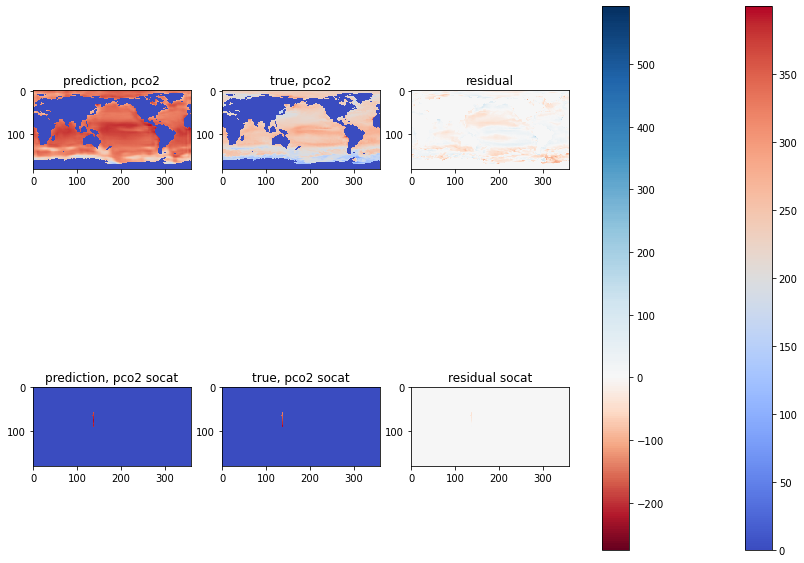

In [66]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 3,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, pco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, pco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[0][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[0][2].set_title("residual")
plt.colorbar(img2,ax=axis)


img3=axis[1][0].imshow(np.flipud(y_pred_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][0].set_title("prediction, pco2 socat")

img4=axis[1][1].imshow(np.flipud(y_true_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("true, pco2 socat")

diff=np.flipud(np.squeeze(y_true_socat[0]-y_pred_socat[0]))

img5=axis[1][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][2].set_title("residual socat")

plt.show()

In [67]:
rmses = []
rmses_socat = []

for i in range(421):    
    rmse =custom_rmse(y_pred[i],y_true[i]).numpy()
    rmses.append(rmse)
    rmse =custom_rmse(y_pred_socat[i],y_true_socat[i]).numpy()
    rmses_socat.append(rmse)
    

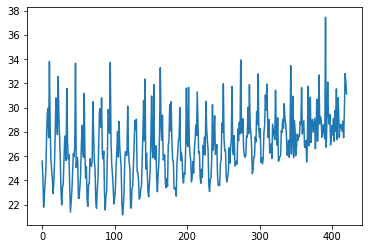

In [68]:
plt.plot(rmses)

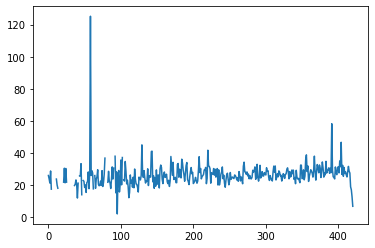

In [69]:
plt.plot(rmses_socat)

(array([1.700000e+01, 6.400000e+01, 1.480000e+02, 3.170000e+02,
        8.990000e+02, 2.463000e+03, 7.491000e+03, 2.389200e+04,
        8.084700e+04, 2.507320e+05, 9.532590e+05, 3.480001e+06,
        1.585112e+07, 4.752783e+06, 1.430891e+06, 3.305370e+05,
        7.262800e+04, 2.486200e+04, 9.620000e+03, 3.976000e+03,
        1.668000e+03, 7.750000e+02, 4.700000e+02, 3.500000e+02,
        2.490000e+02, 2.200000e+02, 1.590000e+02, 1.200000e+02,
        8.500000e+01, 6.900000e+01, 3.300000e+01, 1.700000e+01,
        1.400000e+01, 1.200000e+01, 5.000000e+00, 1.000000e+00,
        3.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00]),
 array([-275.1705  , -253.48485 , -231.7992  , -210.11353 , -188.42787 ,
        -166.74222 , -145.05655 , -123.370895, -101.68524 ,  -79.99959 ,
         -58.313927,  -36.62827 ,  -14.942612,    6.743046,   28.428703,
          50.11436 ,   71.80002 ,   93.48567 ,  115.17133 ,  136.857   ,
         158.54265 ,  180.2283  ,  201.91397 ,  223.59962 ,  245.2

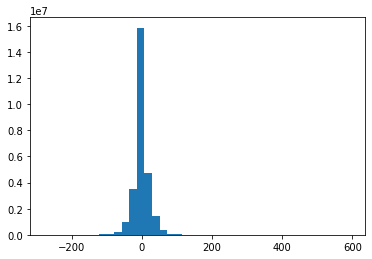

In [70]:
plt.hist(np.array(y_true-y_pred).flatten(),bins=40)

(array([4.0000e+00, 7.0000e+00, 1.4000e+01, 1.4000e+01, 3.2000e+01,
        8.5000e+01, 1.3200e+02, 3.1000e+02, 4.7800e+02, 5.8300e+02,
        9.3900e+02, 1.7800e+03, 3.6220e+03, 7.3490e+03, 1.6013e+04,
        2.5749e+04, 3.3203e+04, 3.5751e+04, 3.7756e+04, 3.1568e+04,
        2.0550e+04, 1.1386e+04, 6.4510e+03, 3.2600e+03, 1.7100e+03,
        7.4200e+02, 3.5500e+02, 2.1100e+02, 1.2500e+02, 7.5000e+01,
        4.8000e+01, 2.6000e+01, 2.0000e+01, 1.6000e+01, 4.0000e+00,
        4.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-184.11297607, -173.94584503, -163.77871399, -153.61158295,
        -143.4444519 , -133.27732086, -123.11018982, -112.94305878,
        -102.77592773,  -92.60879669,  -82.44166565,  -72.27453461,
         -62.10740356,  -51.94027252,  -41.77314148,  -31.60601044,
         -21.43887939,  -11.27174835,   -1.10461731,    9.06251373,
          19.22964478,   29.39677582,   39.56390686,   49.7310379 ,
          59.89816895,   70.06529999,   80.232

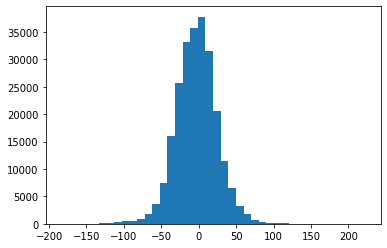

In [71]:
res_socat = np.array(y_true_socat-y_pred_socat).flatten()
res_socat_nonzero = res_socat[res_socat!=0]
plt.hist(res_socat_nonzero,bins=40)

## Canadian Model

In [107]:
can_dir_name = "../../data/can_001"

data,pco2 = preprocess_images(can_dir_name,can=True)
data_socat, pco2_socat = preprocess_images(can_dir_name, socat = True,can=True)

for layer in base_model.layers[:-4]:
    layer.trainable = False
    
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [108]:
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)

model_path="../../models/transfer_can_cnn.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 100
batch_size = 16


history = base_model.fit(
    data,
    pco2,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(data, pco2),
    callbacks=callbacks,
)

Epoch 1/100
27/27 [==============================] - 4s 155ms/step - loss: 5.2480 - val_loss: 3.7693
Epoch 2/100
27/27 [==============================] - 8s 201ms/step - loss: 3.7498 - val_loss: 3.5560
Epoch 3/100
27/27 [==============================] - 3s 129ms/step - loss: 3.6420 - val_loss: 3.4898
Epoch 4/100
27/27 [==============================] - 3s 129ms/step - loss: 3.5842 - val_loss: 3.4594
Epoch 5/100
27/27 [==============================] - 3s 129ms/step - loss: 3.5309 - val_loss: 3.4565
Epoch 6/100
27/27 [==============================] - 3s 130ms/step - loss: 3.5082 - val_loss: 3.4115
Epoch 7/100
27/27 [==============================] - 3s 129ms/step - loss: 3.4802 - val_loss: 3.4057
Epoch 8/100
27/27 [==============================] - 3s 129ms/step - loss: 3.4856 - val_loss: 3.3730
Epoch 9/100
27/27 [==============================] - 3s 130ms/step - loss: 3.5115 - val_loss: 3.3879
Epoch 10/100
27/27 [==============================] - 3s 130ms/step - loss: 3.4331 - val_lo

In [110]:
best_model = tf.keras.models.load_model('../../models/transfer_can_cnn.h5', custom_objects={'custom_rmse':custom_rmse})

pred = best_model.predict(data,verbose=True)

14/14 [==============================] - 1s 69ms/step


In [111]:
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(can_dir_name, can = True)

y_true,y_pred = inverse_scale_image(pred,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat = np.nan_to_num(pco2t2.pCO2_socat.data)
y_pred_socat[y_true_socat==0]=0.0

print("Full RMSE score:")
a=custom_rmse(y_pred,y_true)
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat,y_true_socat)
print(b.numpy())


Full RMSE score:
43.299442
SOCAT RMSE score:
46.05307947720219


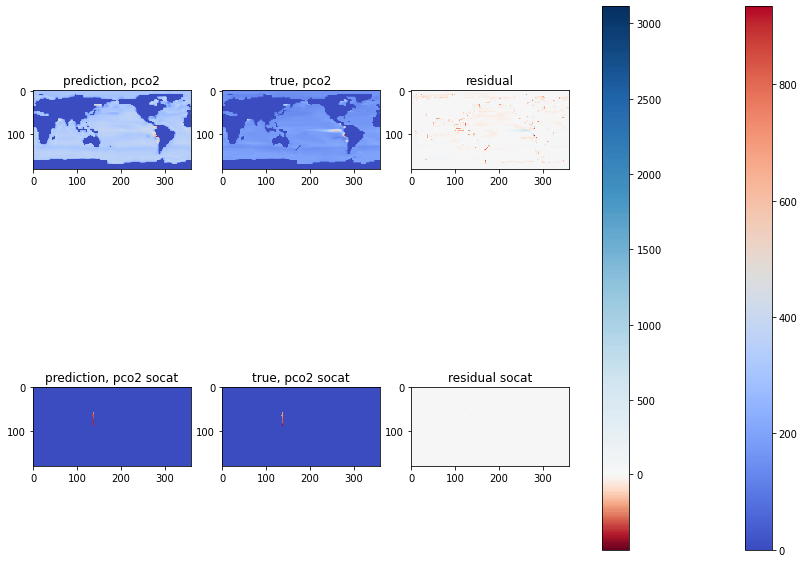

In [116]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 3,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, pco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, pco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[0][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[0][2].set_title("residual")
plt.colorbar(img2,ax=axis)


img3=axis[1][0].imshow(np.flipud(y_pred_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][0].set_title("prediction, pco2 socat")

img4=axis[1][1].imshow(np.flipud(y_true_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("true, pco2 socat")

diff=np.flipud(np.squeeze(y_true_socat[0]-y_pred_socat[0]))

img5=axis[1][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][2].set_title("residual socat")

plt.show()

In [117]:
rmses = []
rmses_socat = []

for i in range(421):    
    rmse =custom_rmse(y_pred[i],y_true[i]).numpy()
    rmses.append(rmse)
    rmse =custom_rmse(y_pred_socat[i],y_true_socat[i]).numpy()
    rmses_socat.append(rmse)

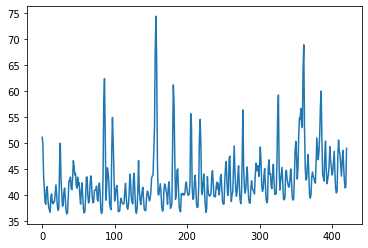

In [118]:
plt.plot(rmses)

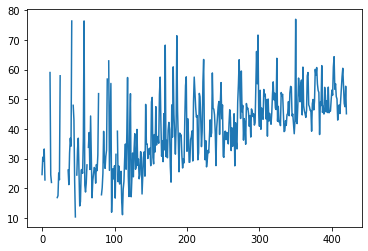

In [119]:
plt.plot(rmses_socat)

(array([2.9100000e+02, 3.3180000e+03, 4.6929000e+04, 1.8674700e+05,
        6.6095400e+05, 2.4943596e+07, 1.3333020e+06, 7.8289000e+04,
        1.4343000e+04, 5.4260000e+03, 2.7210000e+03, 1.6650000e+03,
        1.0340000e+03, 6.6100000e+02, 4.3900000e+02, 2.8200000e+02,
        1.9500000e+02, 1.4200000e+02, 1.0500000e+02, 7.1000000e+01,
        4.3000000e+01, 4.6000000e+01, 4.1000000e+01, 2.8000000e+01,
        2.4000000e+01, 2.2000000e+01, 2.4000000e+01, 6.0000000e+00,
        9.0000000e+00, 8.0000000e+00, 7.0000000e+00, 4.0000000e+00,
        5.0000000e+00, 6.0000000e+00, 6.0000000e+00, 6.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 2.0000000e+00, 2.0000000e+00]),
 array([-495.9901 , -405.7187 , -315.44724, -225.1758 , -134.90436,
         -44.63292,   45.63852,  135.90996,  226.1814 ,  316.45282,
         406.72427,  496.99573,  587.26715,  677.5386 ,  767.81006,
         858.0815 ,  948.3529 , 1038.6244 , 1128.8958 , 1219.1672 ,
        1309.4387 , 1399.7101 , 1489.9816 , 15

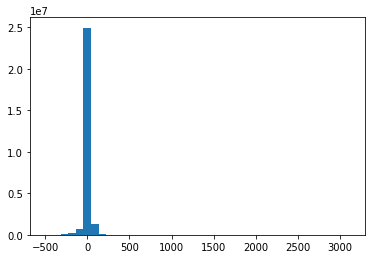

In [120]:
plt.hist(np.array(y_true-y_pred).flatten(),bins=40)

(array([4.20000e+01, 2.99000e+02, 6.64000e+02, 1.84000e+03, 2.73500e+03,
        3.92800e+03, 5.95460e+04, 1.51106e+05, 2.77750e+04, 3.47600e+03,
        7.18000e+02, 1.20000e+02, 6.10000e+01, 3.50000e+01, 1.10000e+01,
        1.20000e+01, 5.00000e+00, 6.00000e+00, 3.00000e+00, 4.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-377.53885841, -324.78831573, -272.03777304, -219.28723035,
        -166.53668766, -113.78614497,  -61.03560228,   -8.2850596 ,
          44.46548309,   97.21602578,  149.96656847,  202.71711116,
         255.46765385,  308.21819654,  360.96873922,  413.71928191,
         466.4698246 ,  519.22036729,  571.97090998,  624.72145267,
         677.47199535,  730.22253804,  782.97308073,  835.72362342,
      

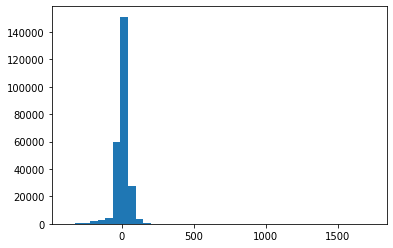

In [121]:
res_socat = np.array(y_true_socat-y_pred_socat).flatten()
res_socat_nonzero = res_socat[res_socat!=0]
plt.hist(res_socat_nonzero,bins=40)